[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/darkmetrics/banks/blob/main/code/demonstration.ipynb)

## Прогнозирование вероятности дефолта для российских банков.

**Авторы**:
* **Волкова Анастасия**
* **Дубленский Иван**
* **Лозовой Владимир**
* **Тельман Куан**

### 1. Загрузка данных и первое знакомство с ними.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt 
import seaborn as sns

# включение множественного вывода для Google Colab
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Слава богу, `pandas` умеет читать данные с интернет-страниц. Важно, что на Гитхабе на страничке файла с данными надо нажать кнопку `raw`, и тогда `url`-ссылка на файл с данными изменится, в тексте ссылки появится слово `raw`. Именно такую ссылку и надо использовать для чтения данных.

In [2]:
url = "https://raw.githubusercontent.com/darkmetrics/banks/main/data/metrics.csv"
url2 = "https://raw.githubusercontent.com/darkmetrics/banks/main/data/defaults.csv"
data = pd.read_csv(url, parse_dates=True, index_col='date')
defaults = pd.read_csv(url2, parse_dates=True, index_col='date')

print('Head of table with bank metrics:\n')
data.head(5)
print('\nHead of table with bank defaults:\n')
defaults.head(5)

Head of table with bank metrics:



,REGN,Year,Month,NetIncome,NetSecurityIncome,NetDerivativeIncome,NetFeeIncome,NetInvestmentIncome,NetInterestIncome,Assets,...,InterbankShareInLiabs,CreditsRetail_Me,ownership_state,form_public,region_notmoscow,Moodys,ExpertRA,DefaultIn365Days,DefaultIn730Days,DefaultIn10000Days
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,1,2015,1,0.007337,-0.080195,1.821275,1.003520,1.127056e-07,3.267442,1.209364e+09,...,0.105845,147875391.0,0,0,0,no,no,0,0,0
2015-02-01,1,2015,2,0.006679,-0.080195,1.821275,1.003520,1.127056e-07,3.267442,1.328361e+09,...,0.112639,145009568.0,0,0,0,no,no,0,0,0
2015-03-01,1,2015,3,0.007374,-0.080195,1.821275,1.003520,1.127056e-07,3.267442,1.203223e+09,...,0.119042,139987699.0,0,0,0,no,no,0,0,0
2015-04-01,1,2015,4,0.002215,-0.075207,1.304973,0.607162,-0.000000e+00,1.858185,1.167734e+09,...,0.096728,135048179.0,0,0,0,no,no,0,0,0
2015-05-01,1,2015,5,0.002413,-0.075207,1.304973,0.607162,-0.000000e+00,1.858185,1.072174e+09,...,0.122466,130841858.0,0,0,0,no,no,0,0,0



Head of table with bank defaults:



,name,REGN,type,region
date,,,,
2021-09-17,Платина,2347,отозв.,Москва
2021-08-06,КС Банк,1752,отозв.,Саранск (Республика Мордовия)
2021-07-23,Руна-Банк,3207,отозв.,Москва
2021-07-23,Русское Финансовое Общество,3427,отозв.,Москва
2021-06-25,Актив Банк,2529,отозв.,Саранск (Республика Мордовия)


Сначала выберем нужные столбцы из метрик.

In [3]:
cols = ['REGN','Assets','personal_page','app','CapitalAdequacy_norm','LiquidityMonth_norm',
        'LiquidityDay_norm','LiquidityLong_norm','CreditsToInsidersCoefficient_norm',
        'ROE','ROA','ReservesChange', 'EquityToImmobilizedAssets', 
        'CreditsReturnCorporates','DepositsInterestCorporates','CreditsReturnRetail','DepositsInterestRetail',
        'CostOfRisk', 'InterbankShareInLiabs','ownership_state','form_public','region_notmoscow',
        'Moodys','ExpertRA',
        # эти столбцы для расчета дополнительных метрик - сами по себе они не нужны
        'Credits_Me','Deposits_Me', 'CreditsCorporates_Me', 'CreditsRetail_Me',
        'IncomeRetail_Me','IncomeCorporates_Me','ExpenditureRetail_Me','ExpenditureCorporates_Me',
        'ExpendituresReserves_Me', 'DepositsRetail_Me','DepositsCorporates_Me']
len(cols)

35

In [4]:
data = data[cols]

Посмотрим на содержимое таблички: типы данных, количество пропусков.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40885 entries, 2015-01-01 to 2016-12-01
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   REGN                               40885 non-null  int64  
 1   Assets                             40885 non-null  float64
 2   personal_page                      40885 non-null  float64
 3   app                                40885 non-null  float64
 4   CapitalAdequacy_norm               40885 non-null  float64
 5   LiquidityMonth_norm                40885 non-null  float64
 6   LiquidityDay_norm                  40885 non-null  float64
 7   LiquidityLong_norm                 40885 non-null  float64
 8   CreditsToInsidersCoefficient_norm  40885 non-null  float64
 9   ROE                                40885 non-null  float64
 10  ROA                                40885 non-null  float64
 11  ReservesChange                     40

И заменим некоторые названия столбцов в данных - с исходными названиями трудновато будет работать.

In [6]:
new_names = {'CapitalAdequacy_norm':'n_1_0',
             'LiquidityMonth_norm':'n3',
             'LiquidityDay_norm':'n2',
             'LiquidityLong_norm':'n4',
             'CreditsToInsidersCoefficient_norm':'n_10_1',
             'ReservesChange':'reserv_chng',
             'EquityToImmobilizedAssets':'equity_immobil',
             'CreditsReturnCorporates':'corp_loan',
             'DepositsInterestCorporates':'corp_depo',
             'CreditsReturnRetail':'retail_loan',
             'DepositsInterestRetail':'retail_depo',
             'CostOfRisk':'cor',
             'InterbankShareInLiabs':'mbk_share', 
             'ownership_state':'owner', 
             'form_public':'public',
             'region_notmoscow':'notmoscow',
             'CreditsCorporates_Me':'corp_loan_abs',
             'CreditsRetail_Me':'retail_loans_abs',
             'DepositsRetail_Me':'retail_depo_abs',
             'DepositsCorporates_Me':'corp_depo_abs',
             'IncomeRetail_Me':'retail_inc',
             'IncomeCorporates_Me':'corp_inc',
             'ExpenditureRetail_Me':'retail_cost',
             'ExpenditureCorporates_Me':'corp_cost',
             'ExpendituresReserves_Me':'reserv_cost'}

data.rename(columns=new_names, inplace=True)
data.columns = [x.lower().replace('_me', '') for x in data.columns]

Посмотрим на детальные описания регрессоров:

In [7]:
meta_url = 'https://raw.githubusercontent.com/darkmetrics/banks/main/data/metadata.csv'
meta = pd.DataFrame(pd.read_csv(meta_url, index_col=0))
meta.index = meta['Название']
meta.drop(columns='Название', inplace=True)
m = meta.style.format()
cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]
}
index_names = {
    'selector': '.index_name',
    'props': 'background-color: #cc7000; color: white;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #cc7000; color: white;'
}
id = list(range(0, 25, 2))
idx = pd.IndexSlice
slice_ = idx[idx[meta.index[id]], idx[:]]
meta = meta.style.set_properties(**{'background-color': '#FCD299'}, subset=slice_, axis=0)
meta.set_table_styles([cell_hover, index_names, headers])

,Краткое название,Содержание
Название,,
CapitalAdequacy_norm,n_1_0,Достаточность капитала
LiquidityMonth_norm,n3,Норматив текущей ликвидности
LiquidityDay_norm,n2,Норматив мгновенной ликвидности
LiquidityLong_norm,n4,Норматив долгосрочной ликвидности
CreditsToInsidersCoefficient_norm,n_10_1,Норматив совокупной величины риска по инсайдерам банка
ReservesChange,reserv_chng,Изменение резрвов за период
EquityToImmobilizedAssets,equity_immobil,Отношение капитала к иммобилизованным активам
CreditsReturnCorporates,corp_loan,Ставки по корпоративным кредитам
DepositsInterestCorporates,retail_depo,Ставки по депозитам для корпоратов


In [8]:
defaults.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2205 entries, 2021-09-17 to 2015-12-25
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    2205 non-null   object
 1   REGN    2205 non-null   int64 
 2   type    2205 non-null   object
 3   region  2205 non-null   object
dtypes: int64(1), object(3)
memory usage: 86.1+ KB


Теперь посмотрим, совпадают ли даты для наборов данных с дефолтами и с метриками.

In [9]:
print(f"Самая ранняя дата в метриках: {data.index.min()}")
print(f"Самая ранняя дата в дефолтах: {defaults.index.min()}")

Самая ранняя дата в метриках: 2015-01-01 00:00:00
Самая ранняя дата в дефолтах: 1991-01-22 00:00:00


Так не годится, отберем данные о дефолтах с 2015 года.

In [10]:
defaults = defaults[defaults.index.year>=2015]
defaults.head(3)

,name,REGN,type,region
date,,,,
2021-09-17,Платина,2347,отозв.,Москва
2021-08-06,КС Банк,1752,отозв.,Саранск (Республика Мордовия)
2021-07-23,Руна-Банк,3207,отозв.,Москва


Теперь надо соединить данные о дефолтах (наша целевая переменная) и данные о финансовых показателях банков.

In [11]:
defaults['default'] = 1
defaults.rename(columns={'REGN':'regn'}, inplace=True)
# в data у нас все наблюдения приходятся на 1 число
defaults['date'] = defaults.index
defaults['date'] = defaults['date'].apply(lambda dt: dt.replace(day=1))
defaults.index = defaults['date']
defaults.drop(columns='date', inplace=True)
defaults.sort_index(inplace=True)

In [12]:
data = pd.merge(left=data, right=defaults[['default', 'regn']], on=['date', 'regn'], how='left')

In [13]:
data.default.fillna(0, inplace=True)

### 2. Предобработка данных и создание новых признаков.

#### 2.1 Числовые признаки.

Для начала нам надо создать новые признаки на основе старых.

Сначала рассчитаем средние ставки по банковской системе. Также сразу посчитаем совокупные активы банковской системы - этот показатель нам тоже пригодится.

In [14]:
avg_cols = ['assets','corp_loan_abs', 'retail_loans_abs',
            'retail_inc','corp_inc','retail_cost', 
            'corp_cost', 'retail_depo_abs','corp_depo_abs']

group_dict = dict(zip(avg_cols, ['sum']*len(avg_cols)))
avg = data.groupby(data.index).agg(group_dict).reset_index()
avg.index = avg['date']
# посчитаем собственно средние ставки
avg['avg_corp_loan'] = avg['corp_inc']/avg['corp_loan_abs']
avg['avg_retail_loan'] = avg['retail_inc']/avg['retail_loans_abs']
avg['avg_corp_depo'] = avg['corp_cost']/avg['corp_depo_abs']
avg['avg_retail_depo'] = avg['retail_cost']/avg['retail_depo_abs']

Нарисуем средние ставки по кредитам и депозитам, это само по себе любопытно и информативно.

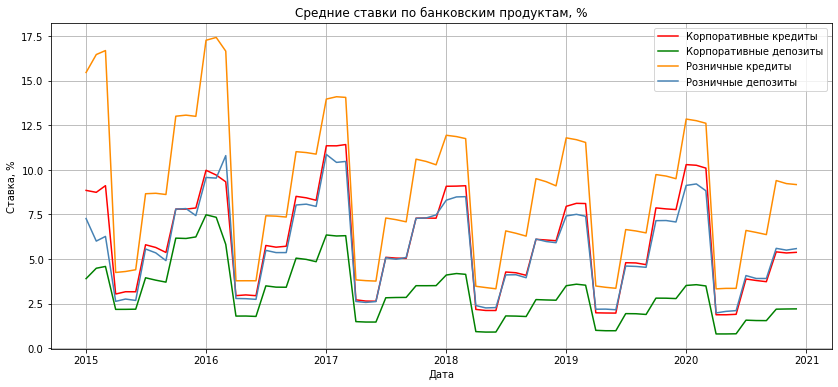

In [15]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(avg.avg_corp_loan*100, color='red', label='Корпоративные кредиты')
ax.plot(avg.avg_corp_depo*100, color='green', label='Корпоративные депозиты')
ax.plot(avg.avg_retail_loan*100, color='darkorange', label='Розничные кредиты')
ax.plot(avg.avg_retail_depo*100, color='steelblue', label='Розничные депозиты')
ax.set_xlabel('Дата')
ax.set_ylabel('Ставка, %')
ax.set_title('Средние ставки по банковским продуктам, %')
ax.legend()
ax.grid(True)
fig.show();

Странновато, конечно, ну да ладно. Теперь приклеим сгруппированный набор данных к основному, чтобы посчитать отклонения от средних ставок по разным продуктам для каждого банка.

In [16]:
avg.rename(columns={'assets':'total_assets'}, inplace=True)

data = pd.merge(left=data, 
                right=avg[['total_assets', 'avg_corp_loan', 'avg_retail_loan', 
                           'avg_corp_depo','avg_retail_depo']],
                how='left',
                left_index=True, right_index=True)

Посчитаем 
1. Разницу между ставками конкретного банка и средними по системе ставками для
  * Корпоративных кредитов
  * Корпоративных депозитов
  * Розничных кредитов
  * Розничных депозитов
2. Отношение кредитов к депозитам (Loan-Deposit Ratio)
3. Доли кредитов в пассивах:
  * Долю всего кредитного портфеля в пассивах
  * Долю корпоративных кредитов в пассивах
  * Долю розничных кредитов в пассивах
4. Отношение активов банка к активам всей банковской системы на соответствующую дату
5. Дисперсию
  * Активов банка
  * Кредитного портфеля банка
  * Корпоративного кредитного портфеля банка

In [17]:
# 1 дифференциалы процентных ставок
data['corp_loan_spread'] = data['avg_corp_loan']-data['corp_loan']
data['retail_loan_spread'] = data['avg_retail_loan']-data['retail_loan']
data['corp_depo_spread'] = data['avg_corp_depo']-data['corp_depo']
data['retail_depo_spread'] = data['avg_retail_depo']-data['retail_depo']
# 2 loan-deposit ratio
data['ldr'] = data['credits']/data['deposits']
# 3 доли кредитов в пассивах
data['loan_share'] = data['credits']/data['assets']
data['ret_loan_share'] = data['retail_loans_abs']/data['assets']
data['corp_loan_share'] = data['corp_loan_abs']/data['assets']
# 4 доля активов банка в активах всей банковской системы
data['size'] = data['assets']/data['total_assets']

Заменим значения, которые равны `np.inf` или `-np.inf`, иначе дальше у нас будут проблемы с расчетами.

In [18]:
data.replace([-np.inf, np.inf], np.nan, inplace=True)

В отдельной ячейке посчитаем три стандартных отклонения. Будем считать их скользящим окном в 12 наблюдений, так как для балансовых показателей у нас месячные данные. Потом поделим на активы банка итого, чтобы нормализовать значения регрессоров.

In [19]:
data['asset_std'] = data.groupby('regn')['assets'].\
                         transform(lambda x: x.rolling(12, 1).std())
data['loan_std'] = data.groupby('regn')['credits'].\
                        transform(lambda x: x.rolling(12, 1).std())
data['corp_loan_std'] = data.groupby('regn')['corp_loan_abs'].\
                             transform(lambda x: x.rolling(12, 1).std())

In [20]:
data['asset_std'] = data['asset_std']/data['assets']
data['loan_std'] = data['loan_std']/data['assets']
data['corp_loan_std'] = data['corp_loan_std']/data['assets']

Посмотрим, остались ли у нас пропуски, если да, то в каких столбцах.

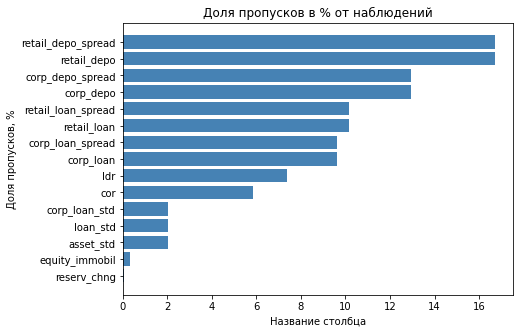

In [21]:
nans = data.isna().sum()[data.isna().sum()!=0]/len(data)
nans = nans.sort_values()

plt.figure(figsize=(7, 5))
plt.barh(nans.index, nans.values*100,  color='steelblue');
plt.xlabel('Название столбца');
plt.ylabel('Доля пропусков, %');
plt.title('Доля пропусков в % от наблюдений');

Какие столбцы нам важны?
* Все столбцы со `spread` - заполним их средними значениями по системе.
* `ldr` - Loan-to-Deposit Ratio.
* `cor` - Cost Of Risk.
* Столбцы с дисперсиями `var`- заполним их средними значениями по системе.
* `equity_immobil`, но в нем мало пропусков, эти наблюдения можно удалить.

Наверно, оптимальный вариант - это заполнить пропущенные ставки значениями, средними по банковской системе на дату пропуска. 

In [22]:
# заполним пропуски в спредах ставок, var и ldr
avg_cols = ['corp_loan_spread', 'retail_loan_spread',
            'corp_depo_spread', 'retail_depo_spread', 
            'ldr', 'cor', 'asset_std', 'loan_std', 'corp_loan_std']

group_dict = dict(zip(avg_cols, ['median']*len(avg_cols)))

avg = data.groupby(data.index).agg(group_dict).reset_index()

avg.index = avg['date']
avg.drop(columns='date', inplace=True)
new_cols = ['avg_' + x for x in avg_cols]
avg.rename(columns=dict(zip(avg_cols, new_cols)), inplace=True)
# приклеим средние значения по банковской системе к нашему датасету
data = pd.merge(left=data, 
                right=avg,
                how='left',
                left_index=True, right_index=True)

In [23]:
# заполним средними значениями пропуски
data.corp_loan_spread.fillna(data.avg_corp_loan_spread, inplace=True)
data.retail_loan_spread.fillna(data.avg_retail_loan_spread, inplace=True)
data.corp_depo_spread.fillna(data.avg_corp_depo_spread, inplace=True)
data.retail_depo_spread.fillna(data.avg_retail_depo_spread, inplace=True)
data.ldr.fillna(data.avg_ldr, inplace=True)
data.cor.fillna(data.avg_cor, inplace=True)
data.asset_std.fillna(data.avg_asset_std, inplace=True)
data.loan_std.fillna(data.avg_loan_std, inplace=True)
data.corp_loan_std.fillna(data.avg_corp_loan_std, inplace=True)

Проверим еще раз наличие пропусков:

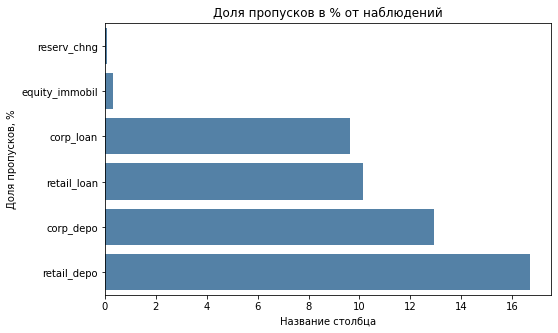

In [24]:
nans = data.isna().sum()[data.isna().sum()!=0]/len(data)
nans = nans.sort_values()

plt.figure(figsize=(8, 5))
sns.barplot(y=nans.index, x=nans.values*100,  color='steelblue');
plt.xlabel('Название столбца');
plt.ylabel('Доля пропусков, %');
plt.title('Доля пропусков в % от наблюдений');

Поменяем знаки у спредов, `roe`, `cor`, `equity_immobil` и Loan-Deposit Ratio:

In [25]:
revert_sign = ['roe', 'cor', 'equity_immobil', 'cor', 'ldr']
for colname in revert_sign:
    data[colname] = data[colname] * -1

Теперь все необходимые признаки получены, можно удалить ненужны столбцы из выборки.

In [26]:
to_drop = ['assets', 'corp_loan', 'corp_depo', 'retail_loan', 'retail_depo',
           'credits', 'deposits', 'corp_loan_abs', 'retail_loans_abs',
           'retail_depo_abs', 'corp_depo_abs', 'total_assets',
           'retail_inc', 'corp_inc', 'retail_cost', 'corp_cost',
           'reserv_cost', 'avg_corp_loan', 'avg_retail_loan', 'avg_corp_depo', 
           'avg_retail_depo', 'reserv_chng',
           'avg_corp_loan_spread', 'avg_retail_loan_spread',
           'avg_corp_depo_spread','avg_retail_depo_spread',
           'avg_ldr','avg_cor','avg_asset_std', 'avg_loan_std', 'avg_corp_loan_std']
data = data[[x for x in data.columns if x not in to_drop]]
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40917 entries, 2015-01-01 to 2020-12-01
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   regn                40917 non-null  int64  
 1   personal_page       40917 non-null  float64
 2   app                 40917 non-null  float64
 3   n_1_0               40917 non-null  float64
 4   n3                  40917 non-null  float64
 5   n2                  40917 non-null  float64
 6   n4                  40917 non-null  float64
 7   n_10_1              40917 non-null  float64
 8   roe                 40917 non-null  float64
 9   roa                 40917 non-null  float64
 10  equity_immobil      40791 non-null  float64
 11  cor                 40917 non-null  float64
 12  mbk_share           40917 non-null  float64
 13  owner               40917 non-null  int64  
 14  public              40917 non-null  int64  
 15  notmoscow           40917 non-null  

In [27]:
data.dropna(inplace=True)

#### Визуализация числовых переменных.

Для начала разделим выборку на train и test.

In [28]:
from sklearn.model_selection import train_test_split

y = data['default']
X = data.drop(columns=['regn', 'default'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=583)

Посмотрим на динамику целевой переменной - дефолтов, попавших в `train`, по годам:

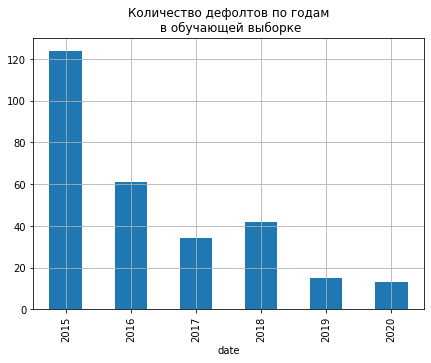

In [29]:
y_train.groupby(y_train.index.year).agg('sum').\
                plot(figsize=(7, 5), kind='bar',
                     title='Количество дефолтов по годам\n в обучающей выборке');
plt.grid(True);

Ситуация вполне логичная: после кризиса 2014 года произошла расчистка банковского сектора, многие банки закрывались в 2015-2016 годах, также тяжелая макроэкономическая ситуация сложилась в России в 2018 году.

#### Визуализация числовых  признаков.

Для начала отберем числовые регрессоры из обучающей выборки:

In [30]:
numeric = X_train.select_dtypes([np.number])
numeric_features = numeric.columns

Посмотрим на корреляционную матрицу между регрессорами:

<Figure size 1152x720 with 0 Axes>

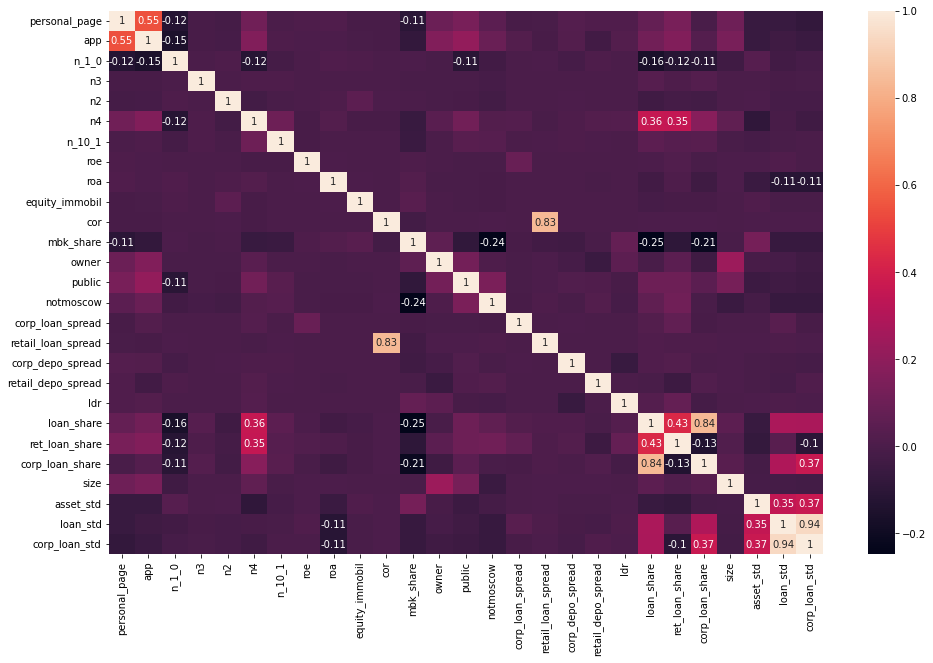

In [31]:
plt.figure(figsize=(16, 10));
ax = sns.heatmap(numeric.corr(), annot=True);
for t in ax.texts:
    if float(t.get_text())>=0.3 or float(t.get_text())<=-0.1:
        t.set_text(t.get_text()); #if the value is greater than 0.4 then I set the text 
    else:
        t.set_text(""); # if not it sets an empty text

Сильная корреляция наблюдается только 
* внутри блоков сходных по смыслу индикаторов: 
  - разных дисперсий балансовых показателей, 
  - долей разных кредитов в пассивах. 
* Отдельно стоит выделить высокую корреляцию между `cor` (Сost of Risk) и `retail_loan_spread` (разница между средней ставкой банка по розничным кредитам и средней ставкой по розничным кредитам для всей банковской системы на конкретный месяц.
* Еще приличная корреляция есть между нормативом Н4 (норматив долгосрочной ликвидности) и долей кредитов в пассивах.

В остальном низкая корреляция между переменными - это либо признак того, что данные собраны криво, либо нам просто повезло. Но это также и хороший знак: не нужно вводить штрафы за высокую корреляцию между регрессорами или отбирать их с помощью VIF.

Нарисуем распределения числовых признаков (увы, слишком много признаков и данных, Питон не смог).

In [32]:
#sns.pairplot(numeric, diag_kind='kde');

### Оценка модели.

Сначала оценим модель безо всяких категориальных признаков, сделаем прогнозы на обучающей выборке (`train`) и тестовой (никогда не поверите, `test`). Пока что абстрагируемся от дисбаланса классов.

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

# забыл выкинуть несколько десятков строк с пропусками

lr = LogisticRegression(random_state=583)
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)
y_train_pred = lr.predict(X_train_scaled)
# получим прогнозы вероятностей для расчета ROC-AUC и так далее
y_pred_p = lr.predict_proba(X_test_scaled)
y_train_pred_p = lr.predict_proba(X_train_scaled)

/home/vladimir/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=583)

Теперь нарисуем ROC-AUC, PR-ROC на тестовой и на обучающей выборке. И вообще посмотрим на различные метрики, насколько хороша наша модель.

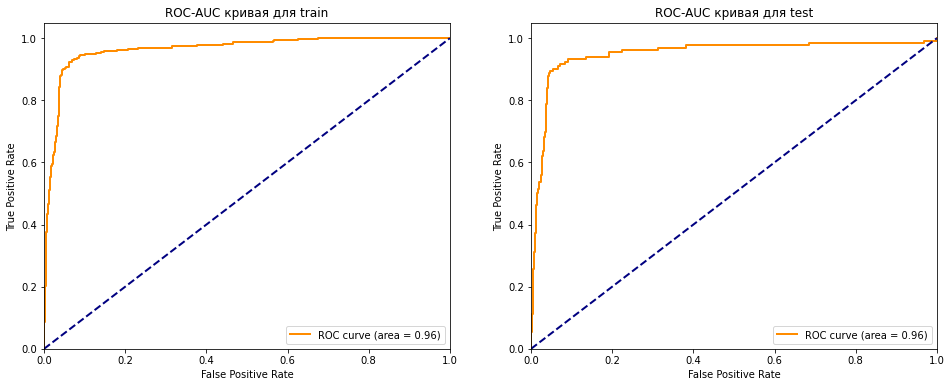

In [52]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_p[:, 1], pos_label=1)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_p[:, 1])
roc_auc_test = auc(fpr_train, tpr_train)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
lw = 2

ax[0].plot(fpr_train,tpr_train,
           color="darkorange",lw=lw,
           label="ROC curve (area = %0.2f)" % roc_auc_train)
ax[0].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("ROC-AUC кривая для train")
ax[0].legend(loc="lower right")

ax[1].plot(fpr_test,tpr_test,
           color="darkorange",lw=lw,
           label="ROC curve (area = %0.2f)" % roc_auc_test)
ax[1].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_title("ROC-AUC кривая для test")
ax[1].legend(loc="lower right")

fig.show();

In [53]:
from sklearn.metrics import classification_report

print('Метрики на train:\n')
print(classification_report(y_train, y_train_pred))
print('\nМетрики на test:\n')
print(classification_report(y_test, y_pred))

Метрики на train:

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     28264
         1.0       0.62      0.02      0.03       289

    accuracy                           0.99     28553
   macro avg       0.81      0.51      0.51     28553
weighted avg       0.99      0.99      0.99     28553


Метрики на test:

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     12106
         1.0       0.67      0.02      0.03       132

    accuracy                           0.99     12238
   macro avg       0.83      0.51      0.51     12238
weighted avg       0.99      0.99      0.98     12238



Посмотрим теперь на значимость признаков. Для этого мы оценим регрессию с помощью библиотеки `statsmodels`:

In [56]:
X_train_scaled.shape

(28553, 27)

In [57]:
lr_sm = sm.Logit(y_train.values, pd.DataFrame(data=X_train_scaled, 
                                              columns=numeric_features))
res = lr_sm.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.692382
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                28553
Model:                          Logit   Df Residuals:                    28526
Method:                           MLE   Df Model:                           26
Date:                Fri, 17 Dec 2021   Pseudo R-squ.:                  -11.24
Time:                        17:08:22   Log-Likelihood:                -19770.
converged:                       True   LL-Null:                       -1614.9
Covariance Type:            nonrobust   LLR p-value:                     1.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
personal_page         -0.0301      0.014     -2.094      0.036      -0.058      -0.002
app  

Как показывает нам отчет, на самом деле все не очень хорошо. Модель явно переобучилась под доминирующий класс: 
* нужен или классификатор помощнее, 
* или надо применять одну из техник для работы с несбалансированными классами, 
* или и то и другое.

К тому же, стоит добавить категориальные признаки.

Поэтому сделаем следующее:
1. Пересмотрим понятие дефолта. Банк ведь не мгновенно уходит в дефолт, допустим, мы считаем дефолтным банк, у которого отзывают лицензию в течение полугода. Почему полгода? Потому что квартал - слишком мало данных (ОПУ публикуется только ежеквартально), год - слишком длинный горизонт, да и в выборке у нас всего несколько лет. Новая целевая переменная даст нам 400 дефолтов * 6 месяцев = 2400 наблюдений с дефолтами, что позволит нам создать сбалансированную выборку.
2. Применим **undersampling**: разобьем данные с дефолтами на `train` и `test`, например, в пропорции 75% и 25%. Получим 1800 наблюдений с дефолтами в `train` и 600 в `test`. Потом случайным образом выберем 1800 и 600 не-дефолтных наблюдений из оставшейся выборки, добавим к `train`, `test`, создадим `X_train`, `X_test`. Итоговая модель может получиться более сбалансированной с точки зрения классов, а значит, есть шанс, что и точность модели будет повыше.
* Данные с не-дефолтами будем брать с 7 месяца 2015, так как занчения некоторых признаков за первые полгода 2015 лучше не использовать (например, дисперсия активов считается скользящим окном за 12 месяцев).

In [63]:
new_defaults = pd.concat([defaults, defaults.shift(-1, freq='MS'),
                          defaults.shift(-2, freq='MS'), defaults.shift(-3, freq='MS'),
                          defaults.shift(-4, freq='MS'), defaults.shift(-5, freq='MS')],
                         axis=0)
new_defaults.sort_index(inplace=True)

In [71]:
data = pd.merge(left=data.drop(columns='default'), 
                right=new_defaults[['default', 'regn']], on=['date', 'regn'], how='left')

In [72]:
data.default.fillna(0, inplace=True)

In [78]:
# отберем в отдельную табличку данные с дефолтами
n_defaults = data[data.default==1].shape[0]
closed = data[data.default==1].sample(frac=1, random_state=123)
# разобьем на train и test
train = closed.iloc[:int(n_defaults*0.75)]
test = closed.iloc[(int(n_defaults*0.75)+1):]
# теперь наберем не-дефолтные наблюдения из выборки
not_closed = data[data.default!=1].sample(n=n_defaults, random_state=123)
train = pd.concat([train, not_closed.iloc[:int(n_defaults*0.75)]], axis=0)
test = pd.concat([test, not_closed.iloc[(int(n_defaults*0.75)+1):]], axis=0)
# перемешаем, так как после склейки табличек дефолты идут в начале
train = train.sample(frac=1, random_state=123)
test = test.sample(frac=1, random_state=123)
X_train = train.drop(columns=['regn', 'default'])
X_test = test.drop(columns=['regn', 'default'])
y_train = train['default']
y_test = test['default']

Повторим все наши предыдущие шаги по оцениванию модели и метрик качества.

In [83]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

# забыл выкинуть несколько десятков строк с пропусками

lr = LogisticRegression(random_state=583)
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)
y_train_pred = lr.predict(X_train_scaled)
# получим прогнозы вероятностей для расчета ROC-AUC и так далее
y_pred_p = lr.predict_proba(X_test_scaled)
y_train_pred_p = lr.predict_proba(X_train_scaled)

LogisticRegression(random_state=583)

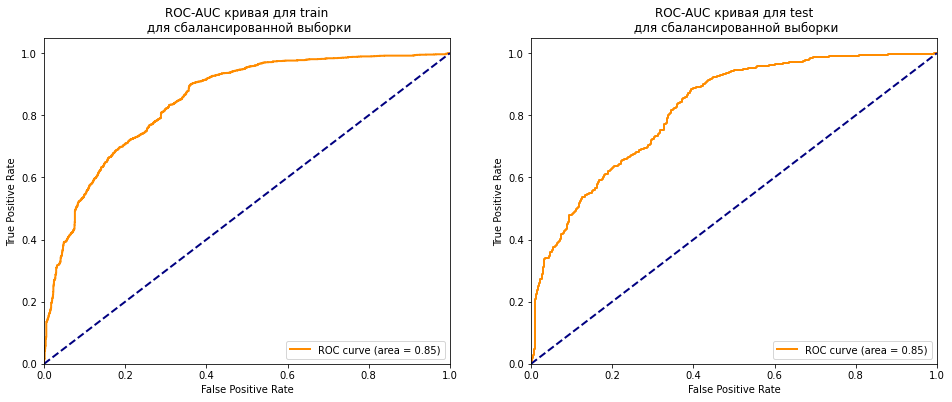

In [86]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_p[:, 1], pos_label=1)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_p[:, 1])
roc_auc_test = auc(fpr_train, tpr_train)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
lw = 2

ax[0].plot(fpr_train,tpr_train,
           color="darkorange",lw=lw,
           label="ROC curve (area = %0.2f)" % roc_auc_train)
ax[0].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("ROC-AUC кривая для train\n для сбалансированной выборки")
ax[0].legend(loc="lower right")

ax[1].plot(fpr_test,tpr_test,
           color="darkorange",lw=lw,
           label="ROC curve (area = %0.2f)" % roc_auc_test)
ax[1].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_title("ROC-AUC кривая для test\n для сбалансированной выборки")
ax[1].legend(loc="lower right")

fig.show();

In [85]:
from sklearn.metrics import classification_report

print('Метрики на train:\n')
print(classification_report(y_train, y_train_pred))
print('\nМетрики на test:\n')
print(classification_report(y_test, y_pred))

Метрики на train:

              precision    recall  f1-score   support

         0.0       0.82      0.66      0.73      2014
         1.0       0.72      0.86      0.78      2014

    accuracy                           0.76      4028
   macro avg       0.77      0.76      0.76      4028
weighted avg       0.77      0.76      0.76      4028


Метрики на test:

              precision    recall  f1-score   support

         0.0       0.79      0.64      0.71       671
         1.0       0.70      0.83      0.76       671

    accuracy                           0.74      1342
   macro avg       0.75      0.74      0.73      1342
weighted avg       0.75      0.74      0.73      1342



Вот это другое дело. Теперь можно посмотреть и на значимость коэффициентов:

In [87]:
lr_sm = sm.Logit(y_train.values, pd.DataFrame(data=X_train_scaled, 
                                              columns=numeric_features))
res = lr_sm.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.486395
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4028
Model:                          Logit   Df Residuals:                     4001
Method:                           MLE   Df Model:                           26
Date:                Fri, 17 Dec 2021   Pseudo R-squ.:                  0.2983
Time:                        18:10:47   Log-Likelihood:                -1959.2
converged:                       True   LL-Null:                       -2792.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
personal_page         -1.2902      0.060    -21.394      0.000      -1.408      -1.172
app 

In [113]:
def coefplot(results):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(res.summary().tables[1].data)
    # Add column names
    coef_df.columns = coef_df.iloc[0]
    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)
    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])
    coef_df = coef_df.astype(float)
    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    # Append errors column to dataframe
    coef_df['errors'] = errors
    # Drop the constant for plotting
    # coef_df = coef_df.drop(['const'])
    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])
    # x-labels
    variables = list(coef_df.index.values)
    # Add variables column to dataframe
    coef_df['variables'] = variables
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    sns.set_context("poster")
    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(15, 5))
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='none', fontsize=12, 
                 ecolor='steelblue',capsize=0,
                 yerr='errors', legend=False)
    # Set title & labels
    plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=14)
    ax.set_ylabel('Coefficients',fontsize=12)
    ax.set_xlabel('',fontsize=12)
    # Coefficients
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='o', s=20, 
               y=coef_df['coef'], color='steelblue')
    # Line to define zero on the y-axis
    ax.grid(True, color='#E8E8E8')
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    return plt.show()

Посмотрим на то, насколько разные регрессоры влияют на вероятность дефолта: поскольку переменные отмасштабированы, коэффициенты можно сравнивать между собой.

/tmp/ipykernel_38/3988240061.py:44: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  ax.scatter(x=pd.np.arange(coef_df.shape[0]),


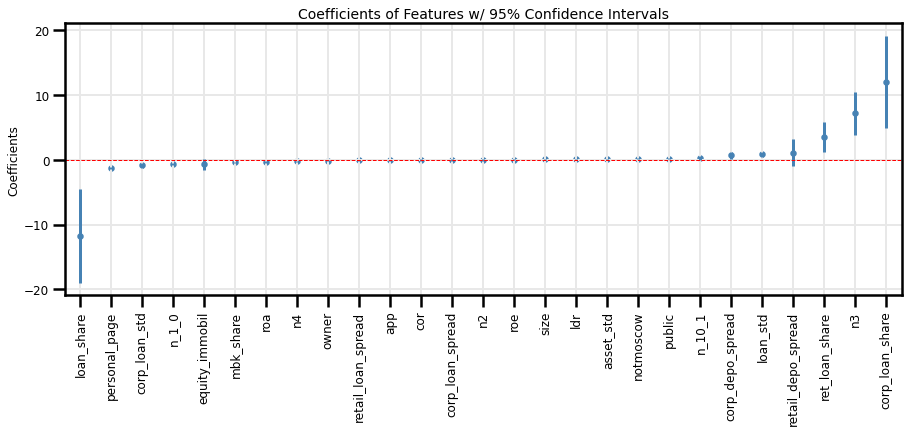

In [114]:
coefplot(res)

#### 2.2 Категориальные признаки.

Посмотрим, что из себя представляют два строковых признака, которые у нас есть:

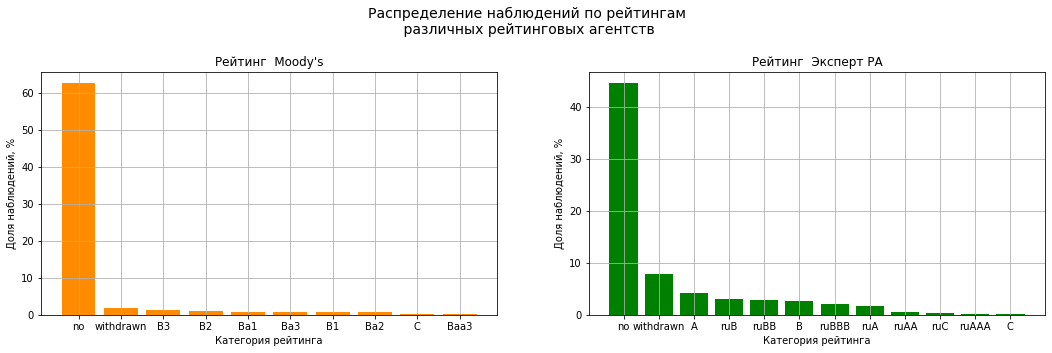

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
fig.subplots_adjust(top=0.8)

ax[0].bar(X_train.moodys.value_counts().index, 
          (X_train.moodys.value_counts()/len(data)*100).values, color='darkorange')
ax[0].set_title("Рейтинг  Moody's")
ax[0].set_xlabel('Категория рейтинга')
ax[0].set_ylabel('Доля наблюдений, %')
ax[0].grid(True)

ax[1].bar(X_train.expertra.value_counts().index, 
          (X_train.expertra.value_counts()/len(data)*100).values, color='green')
ax[1].set_title("Рейтинг  Эксперт РА")
ax[1].set_xlabel('Категория рейтинга')
ax[1].set_ylabel('Доля наблюдений, %')
ax[1].grid(True)

fig.suptitle('Распределение наблюдений по рейтингам\n различных рейтинговых агентств', 
             y=0.98, fontsize=14)
fig.show();

Посмотрим на распределения всех числовых признаков: